## Imports

In [75]:
from tabulate import tabulate
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from fractions import Fraction
from scipy.integrate import solve_ivp
import bisect

## Define All Possible Events (test merge)


In [5]:
def sir_update(S, I, R, N, key):

    if key == 'infection':
        S -= 1
        I += 1
        return S, I, R, N
    elif key == 'recovery':
        R += 1
        I -= 1
        return S, I, R, N
    elif key == 'birth':
        S += 1
        N += 1
        return S, I, R, N
    elif key == 'death S':
        S -= 1
        N -= 1
        return S, I, R, N
    elif key == 'death I':
        I -= 1
        N -= 1
        return S, I, R, N
    elif key == 'death R':
        R -= 1
        N -= 1
        return S, I, R, N




## Implement GSP 

- Add a way to control noise level (gsp function)
    - Larger N reduces noise
    - average results on multiple simulations
    - reduce noise after simultaion: remove high frequency fluctuations

In [6]:
    
def gsp(sir, beta, gamma, mu, end):
    """
    Simulates the disease spread using a Gillespie Stochastic Process (GSP) approach.

    Parameters:
        N (int): Total population size.
        X (int): Initial number of susceptible individuals.
        Y (int): Initial number of infected individuals.
        Z (int): Initial number of recovered individuals.
        beta (float): Infection rate.
        gamma (float): Recovery rate.
        mu (float): Natural death/birth rate.
        end (float): Time until the simulation ends.

    Returns:
        tuple: A list of time events and a list of population data over time.
    """
    S, I, R, N = sir
    t = 0
    
    t_events = []
    y_data = []
    
    while t <= end:
        
        # This queue collects the delta_t of each event at time t + delta_t
        event_queue = {}

        if S > 0 and I > 0 and N > 0:
            dt_infection = np.random.exponential(1/(beta*S*I/N))
            event_queue['infection'] = dt_infection

        if I > 0:
            dt_recovery = np.random.exponential(1/(gamma*I))
            event_queue['recovery'] = dt_recovery

        if N > 0:
            dt_birth = np.random.exponential(1/(mu*N))
            event_queue['birth'] = dt_birth

        if S > 0:
            dt_death_S = np.random.exponential(1/(mu*S))
            event_queue['death S'] = dt_death_S

        if I > 0:
            dt_death_I = np.random.exponential(1/(mu*I))
            event_queue['death I'] = dt_death_I

        if R > 0:
            dt_death_R = np.random.exponential(1/(mu*R))
            event_queue['death R'] = dt_death_R

        
        # Select the event with the smallest delta_t
        sorted_queue = dict(sorted(event_queue.items(), key=lambda item: item[1]))
        first_event_key, first_event_time = list(sorted_queue.items())[0]
        
        t += first_event_time
        t_events.append(t)

        # Handle each type of event
        S, I, R, N = sir_update(S, I, R, N, first_event_key)

        y_data.append([S, I, R])
    
    return (t_events, y_data)

            

        


## Run Stochastic Simulation

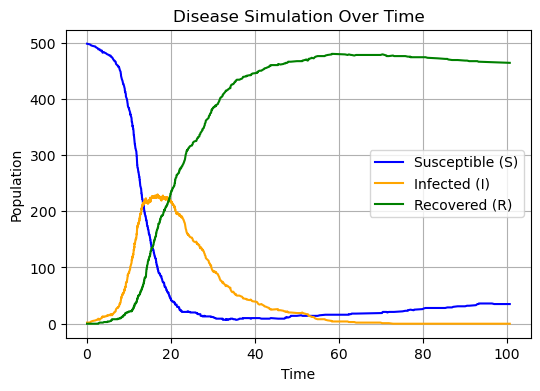

In [7]:
def run_simulation(sir, beta, gamma, mu, t_span):
    """
    Runs the disease simulation and plots the results.

    Parameters:
        N (int): Total population.
        X_0 (int): Initial susceptible population.
        Y_0 (int): Initial infected population.
        Z_0 (int): Initial recovered population.
        beta (float): Infection rate.
        gamma (float): Recovery rate.
        mu (float): Natural birth/death rate.
        t_span (int): Duration of the simulation.
    """

    
    t_events, y_data = gsp(sir, beta, gamma, mu, t_span)

    y_data = np.array(y_data)

    S = y_data[:, 0]
    I = y_data[:, 1]
    R = y_data[:, 2]

    plt.figure(figsize=(6, 4))
    plt.plot(t_events, S, label='Susceptible (S)', color='blue')
    plt.plot(t_events, I, label='Infected (I)', color='orange')
    plt.plot(t_events, R, label='Recovered (R)', color='green')

    plt.xlabel('Time')
    plt.ylabel('Population')
    plt.title('Disease Simulation Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()


# Parameters
N = 500
S = N - 1
I = N - S
R = 0

beta = 0.6
gamma = 0.1
mu = 0.001


t_span = 100

sir = [S, I, R, N]

run_simulation(sir, beta, gamma, mu, t_span)


## Run Deterministic Model

To do:

- Add similarity score between stochastic and derministic model.

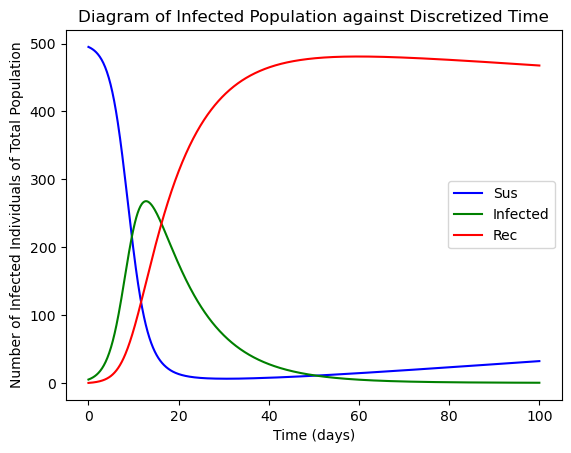

In [8]:
beta = 0.6
gamma = 0.1
mu = 0.001

parameters = [beta, gamma, mu]

t_span = 100

# Initial conditions with 99% susceptible, 1% infected and 0% recovered and a population of 100 people
S0 = 0.99
I0 = 0.01
R0 = 0
N = 500

# Creates a list of initial condition values
initial_conditions = [S0 * N, I0 * N, R0 * N]

# Calculates the ODEs and returns as a list
def calc_ode(t, sir, parameters, N):
    beta, gamma, mu = parameters
    sus, inf, rec = sir
    dSdt = mu*N - ((beta * sus * inf)/ N) - (mu * sus)
    dIdt = ((beta * sus * inf) / N) - (gamma * inf) - (mu * inf)
    dRdt = (gamma * inf) - (mu * rec)
    return [dSdt, dIdt, dRdt]

def plot_sir_ode(time, S, I, R):
    # Plots results
    plt.plot(time, S, label='Sus', color='b')
    plt.plot(time, I, label='Infected', color='g')
    plt.plot(time, R, label='Rec', color='r')
    plt.xlabel('Time (days)')
    plt.ylabel('Number of Infected Individuals of Total Population')
    plt.legend()
    plt.title('Diagram of Infected Population against Discretized Time')
    plt.show()

def run_sir_ode(sir, N, parameters, t_span):
    # Creates an array for each time measurement with 1600 samples, equally spaced between 0 and 1000
    time = np.linspace(0, t_span, 1000)

    # Solves for epidemic scenario with scipy.integrate function solove_ivp: 
    sir_integration = solve_ivp(calc_ode, [time[0], time[-1]], sir, args=(parameters, N), t_eval=time)

    # Assigns y values of sir_integration to correct labels, for later plotting
    S, I, R = sir_integration.y

    plot_sir_ode(time, S, I, R)

run_sir_ode(initial_conditions, N, parameters, t_span)

## Look at variance

- Plot results

- Delete print statements (not yet)

Beta/gamma pairs: [(0.410758347329102, 0.15219098886007876), (0.8816486645063204, 0.5196991818606244), (0.2834849349629973, 0.4548345032684429), (0.7116118681563617, 0.33125642270519845), (0.6656164910724965, 0.23973587416181685), (0.48460212237863887, 0.5052819671829298), (0.8130500514559751, 0.22035130798502225), (0.509348764523389, 0.6398839493533106), (0.5263737939964187, 0.2967091925359723), (0.39914876366438756, 0.19403629862299798), (0.555316838753149, 0.27864488104444957), (0.192940713989604, 0.8596875570275835), (0.30443343235661163, 0.27821979904045235), (0.6601999071764061, 0.4236624938193009), (0.5472575409528383, 0.8850626707511436), (0.5423472008465874, 0.6580551691475486), (0.11998151083513786, 0.12993282471480658), (0.17044428083017343, 0.11857589731180625), (0.1265041688609374, 0.7182102170018407), (0.8050319801898627, 0.6739135697764989), (0.5345117097999758, 0.7177215372217551), (0.4008891535563356, 0.570611208013628), (0.42489230008479895, 0.3143675929276625), (0.52

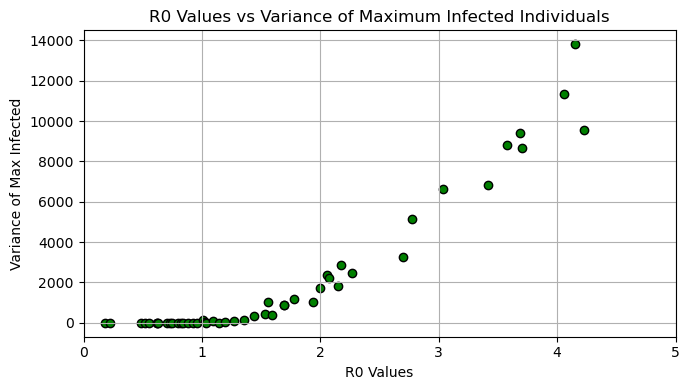

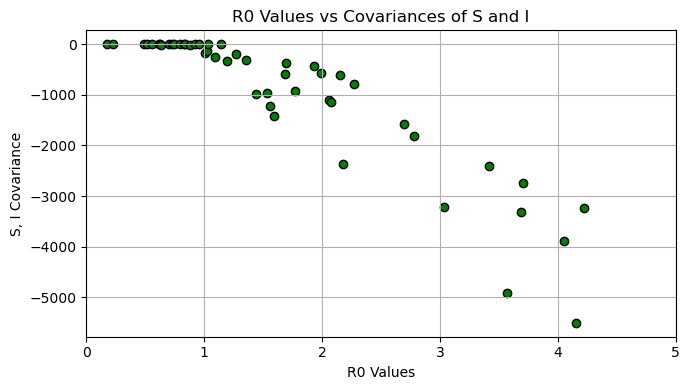

In [9]:
np.random.seed(35)

def generate_parameters(num_samples, lower_ratio=0.45, upper_ratio=0.55, beta_range=(0.1, 0.9), gamma_range=(0.1, 0.9)):
    """
    Generates random beta and gamma pairs, calculates their R0 values, 
    and ensures the ratio of R0 values below and above 1 falls within specified bounds.
    
    Parameters:
        num_samples (int): Number of beta/gamma pairs to generate.
        lower_ratio (float): Lower bound for the ratio of R0 values below and above 1.
        upper_ratio (float): Upper bound for the ratio of R0 values below and above 1.
        beta_range (tuple): Range for beta values.
        gamma_range (tuple): Range for gamma values.
    
    Returns:
        list: List of (beta, gamma) pairs.
        list: List of R0 values.
        float: Ratio of R0 values below and above 1.
    """
    # Initialize ratio of R0 values smaller and larger than 1.
    ratio = 0

    #why?
    while ratio < lower_ratio or ratio > upper_ratio:

        betas = np.random.uniform(beta_range[0], beta_range[1], num_samples)
        gammas = np.random.uniform(gamma_range[0], gamma_range[1], num_samples)

        beta_gamma_pairs = list(zip(betas, gammas))
        R0_vals = [beta / gamma for beta, gamma in beta_gamma_pairs]

        # Calculate the ratio of R0 values < 1 and > 1
        num_below_one = np.sum(np.array(R0_vals) < 1)
        num_above_one = np.sum(np.array(R0_vals) > 1)
        ratio = num_below_one / (num_above_one + 1e-10)  # Avoid division by zero (this is hardcoding, another way?)

    R0_vals
    print("Beta/gamma pairs: " + str(beta_gamma_pairs))
    print("R0 values: " + str(R0_vals))
    print("Ratio: " + str(ratio))
    
    return beta_gamma_pairs, R0_vals




def parameter_sweep(sir, pairs, mu, num_runs):

    """
    Perform a parameter sweep over the SIR model simulation to analyze the impact of varying 
    beta and gamma values on the maximum number of infected individuals.

    Parameters:
    sir : array
        The SIR initial populations.
    pairs : list of tuples
        A list of (beta, gamma) tuples to be tested in the SIR model.
    mu : float
        The recovery rate parameter for the model.
    num_runs : int
        The number of times to run the simulation for each (beta, gamma) pair.

    Returns:
    list
        A list of variances of the maximum infected values for each (beta, gamma) pair.
    """
    
    variances = []
    covariances = []

    for beta, gamma in pairs:
        
        # For variance
        max_I_vals = []

        # For covariance
        S_vals= []
        I_vals = []
        
        # Run simulation n times for each (beta, gamma) pair.
        for _ in range(num_runs):

            result = gsp(sir, beta, gamma, mu, t_span)
            y_data = np.array(result[1])

            S = y_data[:, 0]
            I = y_data[:, 1]
            R = y_data[:, 2]

            S_vals.extend(S)
            I_vals.extend(I)

            # Extract max I value from each run.
            max_I_vals.append(np.max(I))


            
        
        print(f"Beta: {beta}, Gamma: {gamma}, Max Values: {max_I_vals}")
        # Variance for each (beta, gamma) pair after n runs is recorded.
        variances.append(np.var(max_I_vals))
        covariance_matrix = np.cov(S_vals, I_vals)
        covariances.append(covariance_matrix[0, 1])

    return variances, covariances




def plot_R0_vs_variance(R0_vals, variances):
    """
    Plots R0 values against the variances of maximum infected individuals.
    
    Parameters:
        R0_vals (list): List of R0 values.
        variances (list): List of variances corresponding to R0 values.
    """
    plt.figure(figsize=(7, 4))
    plt.scatter(R0_vals, variances, color='green', edgecolor='black')

    plt.xlabel('R0 Values')
    plt.ylabel('Variance of Max Infected')
    plt.title('R0 Values vs Variance of Maximum Infected Individuals')
    #plt.axhline(0, color='gray', linestyle='--')  # Optional: Add a horizontal line at y=0
    plt.grid(True)
    plt.xlim(0, 5)
    plt.tight_layout()
    plt.show()




def plot_R0_vs_covariances(R0_vals, covariances):

    """
    Plots R0 values against the covariances of S and I across different parameter pairs.
    
    Parameters:
        R0_vals (list): List of R0 values.
        covariances (list): List of covariances corresponding to R0 values.
    """
    plt.figure(figsize=(7, 4))
    plt.scatter(R0_vals, covariances, color='green', edgecolor='black')

    plt.xlabel('R0 Values')
    plt.ylabel('S, I Covariance')
    plt.title('R0 Values vs Covariances of S and I')
    #plt.axhline(0, color='gray', linestyle='--')  # Optional: Add a horizontal line at y=0
    plt.grid(True)
    plt.xlim(0, 5)
    plt.tight_layout()
    plt.show()






# Define number of beta/gamma pairs.
num_pairs = 50

# Define number of runs per beta/gamma pair.
num_runs = 10

# Generate Parameters
sample_pairs, sample_R0_vals = generate_parameters(num_pairs)

# Calculate variances
variances, covariances = parameter_sweep(sir, sample_pairs, mu, num_runs)

# Combine and sort by R0 for variance analysis
var_combined = list(zip(sample_R0_vals, variances))
sorted_var_combined = sorted(var_combined)
sorted_R0_vals, sorted_variances = zip(*sorted_var_combined)

# Combine and sort by R0 for variance analysis
covar_combined = list(zip(sample_R0_vals, covariances))
sorted_covar_combined = sorted(covar_combined)
sorted_R0_vals, sorted_covariances = zip(*sorted_covar_combined)




plot_R0_vs_variance(sorted_R0_vals, sorted_variances)
plot_R0_vs_covariances(sorted_R0_vals, sorted_covariances)

## Calculate the Mean accross multiple runs 

147.0865391529762
20.1
[47, 20, 502, 386, 61, 14, 31, 16, 16, 25]


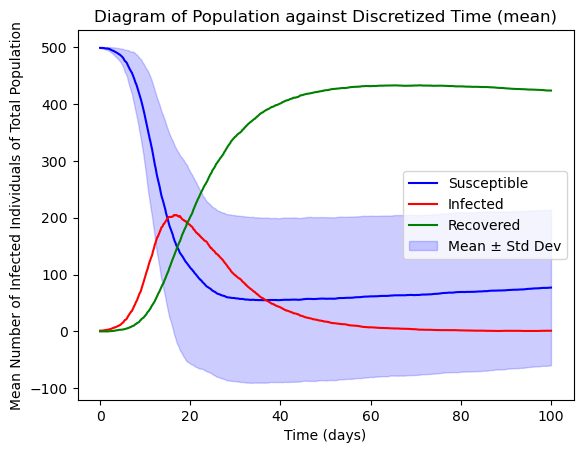

In [117]:
def gsp_mean(runs, t_span, sir, beta, gamma, mu):
    """"
    t_steps: variable that indicates how much spacing is between values for time steps to be recorded
    fixed_steps: an array of steps of t at which sir data is looked at.
    results: a dictionary that holds all the fixed_steps and recorded SIR values for each time steps among #runs

    step_count: Counts 

    t_events: the time evaluation steps for the specific run
    y_data: the sir data that relates to the t_events of the specific run
    
    position_value: gives the current position of the t_event data that is being used in the run in the list of fixed steps   

    
    position value is where in fixed_points, the data should be inserted. double check (correct)
    find the y_data for those values. double check. correct

    access specific s i and r data
              print(f"y data S: {y_data[position_value][0]}")
                print(f"y data I: {y_data[position_value][1]}")
                print(f"y data R: {y_data[position_value][2]}")
    """

    # calculates how large the steps should be in between time steps    
    t_steps = t_span/ 1000
 
    # end excludes end so include t_steps. steps are spacing between values
    fixed_steps = np.round(np.arange(0, t_span + t_steps, t_steps), 2)

    # store data from run at those fixed time steps 
    results = {
        'time': fixed_steps.tolist(),
        'S': {round(step, 4): [] for step in fixed_steps},
        'I': {round(step, 4): [] for step in fixed_steps},
        'R': {round(step, 4): [] for step in fixed_steps},
        'N': {round(step, 4): [] for step in fixed_steps}}
    
    results_mean = {
        'S': [],
        'I': [],
        'R': [],
        'N': []}
    
    results_stdev = {
        'S': [],
        'I': [],
        'R': [],
        'N': []}


    for run in range(runs):
        # get data from run
        t_events , y_data = gsp(sir, beta, gamma, mu, t_span)

        # finds for which values of steps in fixed_steps what the closest (lower) is in t_events.
        for steps in fixed_steps:

            #round the steps similarly to the dictionary
            steps = round(steps, 4)

            #returns where a value should be inserted
            position_value = bisect.bisect_right(t_events, steps)

            #want lowest closest value position, but position can be 0 or higher than max (t_span)
            if position_value > 0:
                position_value -= 1

            S, I, R = y_data[position_value]

            # Appends the corresponding values to the correct place on the timeline
            results['S'][steps].append(S)
            results['I'][steps].append(I)
            results['R'][steps].append(R)
            results['N'][steps].append(S + I + R)

    #access every fixed step
    # access all entries for S, I , R and N in the fixed steps and store mean values in a dictionary
    for steps in fixed_steps:
        
        results_mean['S'].append(np.mean(results['S'][steps]))
        results_mean['I'].append(np.mean(results['I'][steps]))
        results_mean['R'].append(np.mean(results['R'][steps]))
        results_mean['N'].append(np.mean(results['N'][steps]))

        results_stdev['S'].append(np.std(results['S'][steps]))
        results_stdev['I'].append(np.std(results['I'][steps]))
        results_stdev['R'].append(np.std(results['R'][steps]))
        results_stdev['N'].append(np.std(results['N'][steps]))
    
    return results, results_mean, results_stdev

def plot_gsp(results, results_mean, results_stdev):
    
    """
    Plot a graph with the mean as a single line and shaded area around. variance or standard deviation?
    sir together with st dev and just mean with deterministic

    print(S_std[250])
    print(results['time'][201])
    print(results['S'][20.0])

    error bars for stdev
    """

    S_mean = results_mean['S']
    I_mean = results_mean['I']
    R_mean = results_mean['R']

    S = results['S']
    I = results['I']
    R = results['R']

    S_std = results_stdev['S']
    I_std = results_stdev['I']
    R_std = results_stdev['R']

    time = results['time']
    
    plt.plot(time, S_mean, label='Susceptible', color='blue')
    plt.plot(time, I_mean, label='Infected', color='red')
    plt.plot(time, R_mean, label='Recovered', color='green')

    #plt.fill_between(time, np.array(S_mean) - np.array(S_std), 
        #np.array(S_mean) + np.array(S_std), color='blue', alpha=0.2, label='Mean ± Std Dev')

    for time_steps, values in results['S'].items():
        

    plt.scatter(time, S )

    plt.xlabel('Time (days)')
    plt.ylabel('Mean Number of Infected Individuals of Total Population')
    plt.legend()
    plt.title('Diagram of Population against Discretized Time (mean)')
    plt.show()

    return

# Parameters
N = 500
S = N - 1
I = N - S
R = 0

beta = 0.6
gamma = 0.1
mu = 0.001


t_span = 100

sir = [S, I, R, N]

runs = 10

results, results_mean, results_stdev = gsp_mean(runs, t_span, sir, beta, gamma, mu)
plot_gsp(results, results_mean, results_stdev)